# ДЗ №3
1. Взять три гиперпараметра для градиентного бустинга, и для каждого проварьировать один из них, фиксируя остальные. Построить графики зависимости метрики на кросс-валидации от параметра. Прокомментируйте, какие параметры и как влияют на переобучение.
2. Сделать с помощью GridSearchCV и RandomizedSearchCV отбор наилучших параметров.
3. Построить график feature importance. Какие признаки оказались самыми важными?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
sns.set()

from math import floor
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import train_test_split

In [3]:
def cross_validation(train, features, target, scoring_metric='roc_auc', l1=None, solver='lbfgs', penalty='l2', needPrint=True):
    cv_results = cross_val_score(LogisticRegression(solver=solver, penalty=penalty, l1_ratio=l1), train[features], train[target].values.ravel(), cv=5, scoring=scoring_metric)
    
    score = np.mean(cv_results)
    if needPrint:
        print( f'Average = {score}')
    
    return score

In [4]:
def train_and_save_model(train, test, features, target, nameFile, l1=None, solver='lbfgs', penalty='l2'):
    model = LogisticRegression(solver=solver, penalty=penalty, l1_ratio=l1)
    model.fit(X=train[features], y = train[target].values.ravel())
    test_prediction = model.predict_proba(test[features])[:,1]
    sample_submission = pd.read_csv('../data/raw/sample_submission.csv')
    sample_submission[target] = test_prediction
    sample_submission.to_csv(f'HW#3_models/{nameFile}.csv', index = False)

In [5]:
def normalize(sequences):
    return (sequences - sequences.mean()) / (sequences.max() - sequences.min())

In [6]:
train = pd.read_csv('../data/raw/application_train.csv')
test = pd.read_csv('../data/raw/application_test.csv')

In [7]:
def getCV(param, train_data, num_round, nfold=5): 
    res = lgb.cv(param, train_data, num_round)
    auc_mean = res['auc-mean']
    auc_stdv = res['auc-stdv']
    
    return sum(auc_mean) / len(auc_mean)

In [8]:
def getError(model, X_test, y_test):
    res = model.predict(X_test)
    for i in range(len(res)):
        if (res[i] < 0.5):
            res[i] = 0
        else:
            res[i] = 1
        
    y_test_copy = y_test.values.ravel()
    num_invalid = 0
    for i in range(len(res)):
        if (res[i] != y_test_copy[i]):
            num_invalid += 1
            
    return num_invalid / len(res)

In [50]:
def visialize(nameX, nameY1, nameY2, X, Y1, Y2):
    df = pd.DataFrame()
    df[nameX] = X
    df[nameY1] = Y1
    df[nameY2] = Y2
    df[nameY2] = df[nameY2] + df[nameY1].min() - df[nameY2][0]

    fig, ax = plt.subplots()
    ax.plot(df[nameX], df[nameY1])
    ax.plot(df[nameX], df[nameY2])
    ax.get_yaxis().set_visible(False)

#     for i, txt in enumerate(df['model']):
#         ax.annotate(txt, (df['score_cross_val'][i], df['score_kaggle'][i]))

    plt.xlabel(nameX)
    plt.legend([nameY1, nameY2])
    plt.show()

In [10]:
def save_model(fileName, ypred):
    sample_submission = pd.read_csv('../data/raw/sample_submission.csv')
    sample_submission[target] = ypred
    sample_submission.to_csv(f'HW#3_models/{fileName}.csv', index = False)

### Задание №1

In [11]:
features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']
target = ['TARGET']

In [12]:
median_train_amt_annuity = train['AMT_ANNUITY'].median()
train['AMT_ANNUITY'] = train['AMT_ANNUITY'].fillna(median_train_amt_annuity)
test['AMT_ANNUITY'] = test['AMT_ANNUITY'].fillna(median_train_amt_annuity)

In [13]:
categorical_features = ['CODE_GENDER', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR',
             'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE']
features += categorical_features

train['CODE_GENDER'] = train['CODE_GENDER'].replace( { 'M':1,'F':0, 'XNA': 0  })
test['CODE_GENDER'] = test['CODE_GENDER'].replace( { 'M':1,'F':0, 'XNA': 0  })

train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].replace( { 'Y':1,'N':0  })
test['FLAG_OWN_REALTY'] = test['FLAG_OWN_REALTY'].replace( { 'Y':1,'N':0  })

train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].replace( { 'Y':1,'N':0  })
test['FLAG_OWN_CAR'] = test['FLAG_OWN_CAR'].replace( { 'Y':1,'N':0  })

dict_education = {'Secondary / secondary special': 1, 'Higher education': 3,
       'Incomplete higher': 2, 'Lower secondary': 0, 'Academic degree': 4}
train['NAME_EDUCATION_TYPE'] = train['NAME_EDUCATION_TYPE'].replace(dict_education)
test['NAME_EDUCATION_TYPE'] = test['NAME_EDUCATION_TYPE'].replace(dict_education)

dict_family_stat = {'Single / not married': 0, 'Married': 2, 'Civil marriage': 1, 'Widow': 4,
       'Separated': 3, 'Unknown': 0 }
train['NAME_FAMILY_STATUS'] = train['NAME_FAMILY_STATUS'].replace(dict_family_stat)
test['NAME_FAMILY_STATUS'] = test['NAME_FAMILY_STATUS'].replace(dict_family_stat)

dict_income_type = {'Working': 3, 'State servant': 5, 'Commercial associate': 6, 'Pensioner': 7,
       'Unemployed': 0, 'Student': 1, 'Businessman': 4, 'Maternity leave': 2}
train['NAME_INCOME_TYPE'] = train['NAME_INCOME_TYPE'].replace(dict_income_type)
test['NAME_INCOME_TYPE'] = test['NAME_INCOME_TYPE'].replace(dict_income_type)

train[features] = normalize(train[features])
test[features] = normalize(test[features])

In [14]:
features

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'CODE_GENDER',
 'FLAG_OWN_REALTY',
 'FLAG_OWN_CAR',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_INCOME_TYPE']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train[features], train[target], test_size=0.33, random_state=42)

In [16]:
train_data = lgb.Dataset(
    X_train, 
    label=y_train,
    feature_name=features, 
    free_raw_data=False
)

In [17]:
num_round = 20
default_param = {
    'objective': 'binary', 'metric': 'auc', 'verbosity': -1,
    'num_leaves': 31, 'num_iterations': 100, 'learning_rate': 0.1
}

In [18]:
param = default_param.copy()
num_leaves = [2, 5, 10, 20, 50, 100, 200, 500]
res_num_leaves = []
err_num_leaves = []
for i in num_leaves:
    param['num_leaves'] = i
    res_num_leaves.append(getCV(param, train_data, num_round))
    err_num_leaves.append(getError(lgb.train(param, train_data, num_round), X_test, y_test))

/Users/kusok_dobra/PycharmProjects/ML-MIPT-HomeCreditBank/venv/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kusok_dobra/PycharmProjects/ML-MIPT-HomeCreditBank/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kusok_dobra/PycharmProjects/ML-MIPT-HomeCreditBank/venv/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kusok_dobra/PycharmProjects/ML-MIPT-HomeCreditBank/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instea

In [19]:
param = default_param.copy()
num_iterations = [10, 20, 50, 100, 200, 500, 700]
res_num_iterations = []
err_num_iterations = []
for i in num_iterations:
    param['num_iterations'] = i
    res_num_iterations.append(getCV(param, train_data, num_round))
    err_num_iterations.append(getError(lgb.train(param, train_data, num_round), X_test, y_test))
    

/Users/kusok_dobra/PycharmProjects/ML-MIPT-HomeCreditBank/venv/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kusok_dobra/PycharmProjects/ML-MIPT-HomeCreditBank/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kusok_dobra/PycharmProjects/ML-MIPT-HomeCreditBank/venv/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kusok_dobra/PycharmProjects/ML-MIPT-HomeCreditBank/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instea

In [20]:
param = default_param.copy()
learning_rate = [0.001, 0.01, 0.1, 1, 2, 3, 4]
res_learning_rate = []
err_learning_rate = []
for i in learning_rate:
    param['learning_rate'] = i
    res_learning_rate.append(getCV(param, train_data, num_round))
    err_learning_rate.append(getError(lgb.train(param, train_data, num_round), X_test, y_test))

/Users/kusok_dobra/PycharmProjects/ML-MIPT-HomeCreditBank/venv/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kusok_dobra/PycharmProjects/ML-MIPT-HomeCreditBank/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kusok_dobra/PycharmProjects/ML-MIPT-HomeCreditBank/venv/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kusok_dobra/PycharmProjects/ML-MIPT-HomeCreditBank/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instea

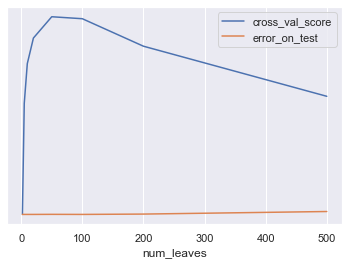

In [51]:
visialize('num_leaves', 'cross_val_score', 'error_on_test', num_leaves, res_num_leaves, err_num_leaves)

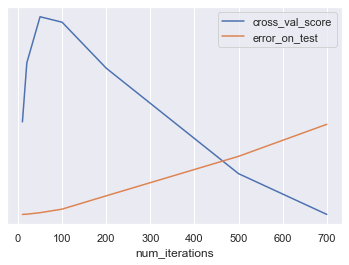

In [52]:
visialize('num_iterations', 'cross_val_score', 'error_on_test', num_iterations, res_num_iterations, err_num_iterations)

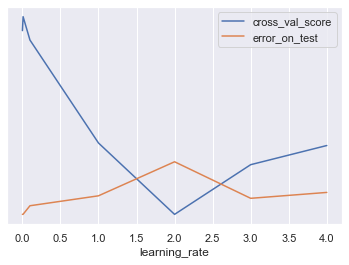

In [53]:
visialize('learning_rate', 'cross_val_score', 'error_on_test', learning_rate, res_learning_rate, err_learning_rate)

Вывод: были выбраны три гиперпараметра, число листьев дерева (num_leaves), скорость обучения (learning_rate) и количество деревьев (num_iterations). Для каждого гиперпараметра найдены оптимальные значения, если значения гиперпарметра превышает оптимальное количество, то модель переучивается и точность падает. Для каждого гиперпараметра приведена пара картинок: результат score для кросс-валидации и ошибка для тестовой выборки.

### Задание №2

In [41]:
parametrs = {
    'num_leaves': num_leaves, 'num_iterations': num_iterations, 'learning_rate': 
}
csf = LGBMClassifier(objective='binary',  metric='auc')
grid = GridSearchCV(csf, parametrs, cv=5, scoring='roc_auc', n_jobs=1)
grid.fit(train_data.data, train[target].values.ravel())

/Users/kusok_dobra/PycharmProjects/ML-MIPT/env/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kusok_dobra/PycharmProjects/ML-MIPT/env/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kusok_dobra/PycharmProjects/ML-MIPT/env/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kusok_dobra/PycharmProjects/ML-MIPT/env/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use i

{'learning_rate': 0.1, 'num_iterations': 500, 'num_leaves': 20}

In [43]:
parametrs = {
   'num_leaves': num_leaves, 'num_iterations': num_iterations, 'learning_rate': learning_rate
}
csf = LGBMClassifier(objective='binary',  metric='auc')
random_search = RandomizedSearchCV(csf, parametrs, cv=5, scoring='roc_auc', n_jobs=1)
random_search.fit(train[features], train[target].values.ravel())

/Users/kusok_dobra/PycharmProjects/ML-MIPT/env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/Users/kusok_dobra/PycharmProjects/ML-MIPT/env/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kusok_dobra/PycharmProjects/ML-MIPT/env/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kusok_dobra/PycharmProjects/ML-MIPT/env/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params.

{'num_leaves': 20, 'num_iterations': 500, 'learning_rate': 0.1}

In [46]:
print("Best GridSearchCV params:", grid.best_params_)
print("Best RandomizedSearchCV params:", random_search.best_params_)

Best GridSearchCV params: {'learning_rate': 0.1, 'num_iterations': 500, 'num_leaves': 20}
Best RandomizedSearchCV params: {'num_leaves': 20, 'num_iterations': 500, 'learning_rate': 0.1}


### Задание №3

In [24]:
bst = lgb.train(default_param, train_data, num_round)

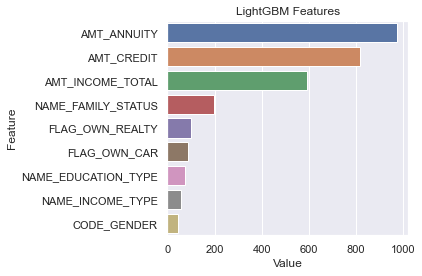

In [190]:
feature_imp = pd.DataFrame({'Value':bst.feature_importance(),'Feature':features})
plt.figure()
# sns.set(font_scale = 1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                    ascending=False)[0:len(features)])
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

### Cтекинг
Используем реализацию https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
1. Построить стекинг для 5 различных моделей по вашему выбору с разными параметрами. Можете взять любые, например 2 бустинга, 2 случайных леса, лог рег. Записать скор на тестовой выборке.
2. Теперь уберем из ансамбля наилучшую модель и снова постройте стекинг. Как изменился результат? Прокомментируйте.

### Задание 1

In [48]:
estimators = [
     ('rf1', RandomForestClassifier(n_estimators=10, random_state=42)),
     ('rf2', RandomForestClassifier(n_estimators=30, random_state=42)),
     ('logreg', LogisticRegression()),
     ('naive bayes', GaussianNB()),
     ('boost', 
      make_pipeline(
         StandardScaler(),
         GaussianNB()
      )
     ),
     
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
clf.fit(train[features], train[target])

/Users/kusok_dobra/PycharmProjects/ML-MIPT/env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kusok_dobra/PycharmProjects/ML-MIPT/env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


StackingClassifier(estimators=[('rf1',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('rf2',
                                RandomForestClassifier(n_estimators=30,
                                                       random_state=42)),
                               ('logreg', LogisticRegression()),
                               ('naive bayes', GaussianNB()),
                               ('boost',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('gaussiannb',
                                                 GaussianNB())]))],
                   final_estimator=LogisticRegression())

In [49]:
ypred_clf = clf.predict_proba(test[features])[:,1]
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')
sample_submission[target] = ypred_clf
sample_submission.to_csv(f'HW#3_models/model2.csv', index = False)

### Score на тестовой выборке = 0.60690

### Задание 2
Поиск лучшей модели

In [50]:
ypred = clf.estimators_[0].predict_proba(test[features])[:,1]
save_model('model2_0', ypred)

Score: 0.50844

In [51]:
ypred = clf.estimators_[1].predict_proba(test[features])[:,1]
save_model('model2_1', ypred)

Score: 0.52641

In [52]:
ypred = clf.estimators_[2].predict_proba(test[features])[:,1]
save_model('model2_2', ypred)

Score: 0.61634

In [53]:
ypred = clf.estimators_[3].predict_proba(test[features])[:,1]
save_model('model2_3', ypred)

Score: 0.50366

In [54]:
ypred = clf.estimators_[4].predict_proba(test[features])[:,1]
save_model('model2_4', ypred)

Score: 0.50361

Самая лучшая модель - логистическая регрессия, выкиним ее.

In [55]:
estimators = [
     ('rf1', RandomForestClassifier(n_estimators=10, random_state=42)),
     ('rf2', RandomForestClassifier(n_estimators=30, random_state=42)),
     ('naive bayes', GaussianNB()),
     ('boost', 
      make_pipeline(
         StandardScaler(),
         GaussianNB()
      )
     ),
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
clf.fit(train[features], train[target])

/Users/kusok_dobra/PycharmProjects/ML-MIPT/env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kusok_dobra/PycharmProjects/ML-MIPT/env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


StackingClassifier(estimators=[('rf1',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('rf2',
                                RandomForestClassifier(n_estimators=30,
                                                       random_state=42)),
                               ('naive bayes', GaussianNB()),
                               ('boost',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('gaussiannb',
                                                 GaussianNB())]))],
                   final_estimator=LogisticRegression())

In [56]:
ypred_clf = clf.predict_proba(test[features])[:,1]
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')
sample_submission[target] = ypred_clf
sample_submission.to_csv(f'HW#3_models/model3.csv', index = False)

Score: 0.52338

Убрав лучшую модель, стекинг стал хуже предсказывать результат, что очевидно, так как стекинг  основывает свой результат на мета-факторах, предсказания которых ниже, чем лучшей модели.